# Datascience with Ericsson

In [1]:
# help notebook find src module
import sys

sys.path.append(".")

### Dokonaj konwersji dostępnych danych z drivetestów na DataFrame

In [2]:
from src.cell_pooler import CellPooler
from src.helper import read_all_data

raw_data = read_all_data("./data/new/with_pci")
# raw_data = read_all_data("./data/krakow")
extr = CellPooler(raw_data)

data = extr.points
data.info()
data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182 entries, 0 to 194
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   time         182 non-null    datetime64[ns]
 1   latitude     182 non-null    float64       
 2   longitude    182 non-null    float64       
 3   accuracy     182 non-null    float64       
 4   pci          182 non-null    object        
 5   bts_cell_id  182 non-null    object        
 6   lte          182 non-null    object        
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 11.4+ KB


,time,latitude,longitude,accuracy,pci,bts_cell_id,lte
0,2024-01-07 21:55:48,50.043976,19.955297,9.971,[19],{260-06},"[{'signal': {'rssi': -65, 'rsrp': -103, 'rsrq'..."
1,2024-01-07 21:55:58,50.043966,19.955407,17.131,[19],{260-06},"[{'signal': {'rssi': -69, 'rsrp': -105, 'rsrq'..."
2,2024-01-07 21:56:07,50.043881,19.955436,19.444,[19],{260-06},"[{'signal': {'rssi': -59, 'rsrp': -93, 'rsrq':..."
3,2024-01-07 21:56:18,50.043876,19.955529,21.244,[19],{260-06},"[{'signal': {'rssi': -59, 'rsrp': -95, 'rsrq':..."
4,2024-01-07 21:56:27,50.044069,19.956576,22.205,[214],{260-06},"[{'signal': {'rssi': -55, 'rsrp': -88, 'rsrq':..."
...,...,...,...,...,...,...,...
190,2024-01-07 22:35:47,50.043679,19.951091,8.644,[19],{260-06},"[{'signal': {'rssi': -51, 'rsrp': -82, 'rsrq':..."
191,2024-01-07 22:35:59,50.043561,19.951416,82.576,[19],{260-06},"[{'signal': {'rssi': -63, 'rsrp': -100, 'rsrq'..."
192,2024-01-07 22:36:07,50.043615,19.952135,12.576,[19],{260-06},"[{'signal': {'rssi': -65, 'rsrp': -102, 'rsrq'..."
193,2024-01-07 22:36:25,50.043734,19.953803,71.759,[19],{260-06},"[{'signal': {'rssi': -57, 'rsrp': -93, 'rsrq':..."


### Zwizualizuj punkty pomiarowe na interaktywnej mapie

In [3]:
import plotly.express as px

# mapbox_token: str = os.environ.get("MAPBOX_TOKEN")

fig = px.scatter_mapbox(
    data,
    lat="latitude",
    lon="longitude",
)
fig.update_geos(fitbounds="locations")
fig.update_layout(
    margin={"r": 0, "t": 0, "l": 0, "b": 0},
    mapbox={
        "style": "open-street-map",
        # "accesstoken": mapbox_token, # open-street-map does not require a token
    },
)
fig.show()

### Kryteria doboru danych

Przyklady:
- Wyświetl wszystkie punkty dla PCI X
- Wyświetl wszystkie punkty dla MNC Y
- Wyświetl wszystkie punkty dla PCI X, pokolorowane wg RSRP/RSRQ/RSSI/TA
- Wyświetl wszystkie punkty dla EARFCN Z

In [4]:
# TODO: add filters in filters.py


### Mimika eventów measurementowych

- Zaimplementuj funkcjonalność, która wygeneruje DataFrame zawierającą potencjalne eventy measurementowe i zwizualizuje ją
- Zaimplementuj sterowalne parametry eventów
- Ogranicz się do eventów A1-A5

In [19]:
import pandas as pd

# params to detect events
rsrp_th = [-140, -44]
rsrq_th = [-19.5, -3]
offset = [-15, 15]

events_data = []
size = data.shape[0]
for i, row in data.iterrows():
    cells = row["lte"]
    if cells and 0 < i < size:
        # present cells - ta should be close to 0, ex. 0-10, mcc and mnc should exist
        scell = None
        for scell_index, cell_info in enumerate(cells):
            if cell_info["identity"]["mMnc"] is not None:
                scell = cell_info
                break

        # previous cells
        prev_scell = None
        prev_cells = data.iloc[i - 1]["lte"]
        for cell_info in prev_cells:
            if cell_info["identity"]["mMnc"] is not None:
                prev_scell = cell_info
                break

        assert scell is not None
        assert prev_scell is not None

        scell_rsrp = scell["signal"]["rsrp"]
        scell_rsrq = scell["signal"]["rsrq"]
        pscell_rsrp = prev_scell["signal"]["rsrp"]
        pscell_rsrq = prev_scell["signal"]["rsrq"]

        def is_a1_event():
            return ((scell_rsrp > rsrp_th[0]) and (pscell_rsrp < rsrp_th[0])) or (
                (scell_rsrq > rsrq_th[0]) and (pscell_rsrq < rsrq_th[0])
            )

        def is_a2_event():
            return ((scell_rsrp < rsrp_th[0]) and (pscell_rsrp > rsrp_th[0])) or (
                (scell_rsrq < rsrq_th[0]) and (pscell_rsrq > rsrq_th[0])
            )

        events_detected: list[str] = []
        if is_a1_event():
            events_detected.append("A1")

        if is_a2_event():
            events_detected.append("A2")

        for j, ncell in enumerate(cells):
            if j == scell_index:  # shouldn't check serving cell against itself
                continue

            ncell_rsrp = ncell["signal"]["rsrp"]
            ncell_rsrq = ncell["signal"]["rsrq"]

            def is_a3_event():
                return (ncell_rsrp >= (scell_rsrp + offset[1])) or (
                    ncell_rsrq >= (scell_rsrq + offset[1])
                )

            def is_a4_event():
                return (ncell_rsrp >= rsrp_th[0]) or (ncell_rsrq >= rsrq_th[0])

            def is_a5_event():
                return ((scell_rsrp < rsrp_th[0]) and (ncell_rsrp > rsrp_th[0])) or (
                    (scell_rsrq < rsrq_th[0]) and (ncell_rsrq > rsrq_th[0])
                )

            if is_a3_event():
                events_detected.append("A3")

            if is_a4_event():
                events_detected.append("A4")

            if is_a5_event():
                events_detected.append("A5")

        for ev in set(events_detected):
            events_data.append(
                [
                    row["longitude"],
                    row["latitude"],
                    ev,
                    row["lte"][scell_index]["signal"]["rsrp"],
                    row["lte"][scell_index]["signal"]["rsrq"],
                    row["lte"][scell_index]["identity"]["pci"],
                    row["lte"][scell_index]["identity"]["mMnc"],
                    row["lte"][scell_index]["signal"]["ta"],
                    row["lte"][scell_index]["signal"]["rssi"],
                ]
            )

events_data = pd.DataFrame(
    events_data,
    columns=[
        "longitude",
        "latitude",
        "event",
        "rsrp",
        "rsrq",
        "pci",
        "mnc",
        "ta",
        "rssi",
    ],
)
events_data

,longitude,latitude,event,rsrp,rsrq,pci,mnc,ta,rssi
0,19.955436,50.043881,A4,-93,-14,19,6,2147483647,-59
1,19.955529,50.043876,A3,-95,-15,19,6,2,-59
2,19.955529,50.043876,A4,-95,-15,19,6,2,-59
3,19.956576,50.044069,A4,-88,-14,214,6,2147483647,-55
4,19.957679,50.043859,A4,-90,-9,214,6,2,-61
...,...,...,...,...,...,...,...,...,...
188,19.953765,50.045624,A4,-99,-17,18,6,2147483647,-61
189,19.953823,50.047085,A4,-99,-14,18,6,3,-63
190,19.953140,50.046989,A4,-100,-14,18,6,2147483647,-65
191,19.952341,50.046841,A4,-95,-12,18,6,2,-61


In [20]:
event_types = ["A1", "A2", "A3", "A4", "A5"]
colors = ["black", "blue", "forestgreen", "red", "magenta"]
event_colors_mapper = dict(zip(event_types, colors))

fig = px.scatter_mapbox(
    data_frame=events_data,
    lat="latitude",
    lon="longitude",
    title="A1-A5 Events",
    category_orders={"event": event_types},  # sort labels in legend
    color="event",  # set the color based on string in 'event' column
    color_discrete_map=event_colors_mapper,  # because 'event' column does not store colors directly, specify a mapper event->color
    hover_name="event",
    hover_data={
        "longitude": True,
        "latitude": True,
        "rsrp": True,
        "rsrq": True,
        "event": False,
    },
    width=1200,
    height=600,
)

fig.update_geos(fitbounds="locations")
fig.update_layout(
    margin={"r": 30, "t": 30, "l": 0, "b": 0},
    mapbox={
        "style": "open-street-map",
    },
)
fig.show()

### Kategoryzacja danych

- Grupowanie zarejestrowanych pomiarów przy pomocy współrzędnych geograficznych nie jest ‘wygodne’ - powoduje to utrudnienia implementacyjne podczas aplikowania modeli do analizy danych
- Zaimplementuj funkcjonalność, która wygeneruje siatkę kwadratów o zadanej wielkości, w warunkach brzegowych wybranej mapy.
- Każdy kwadrat ma być ograniczony współrzędnymi {x1, y1}, {x2, y2}
- Każdy kwadrat ma mieć kolejny unikatowy identyfikator
- Identyfikator ten ma być kategorią (label) danego punktu pomiarowego leżącego w granicach wygenerowanego kwadratu
- Podczas implementacji uwzględnij zarówno kategoryzację danych surowych, jak i mimiki eventów.

In [9]:
# GRID SETTINGS
PADDING: float = 0.01  # space between edges of a grid and the most distant points from the center of the grid, measured in longitude/latitude degrees
CHUNKS_COUNT: int = (
    10  # number of chunks per axis so total number of chunks is CHUNKS_COUNT^2
)

In [21]:
min_longitude, max_longitude = (
    events_data["longitude"].min() - PADDING,
    events_data["longitude"].max() + PADDING,
)
min_latitude, max_latitude = (
    events_data["latitude"].min() - PADDING,
    events_data["latitude"].max() + PADDING,
)


def pattern(min_long, min_lat, max_long, max_lat):
    return [
        [min_long, min_lat],
        [max_long, min_lat],
        [max_long, max_lat],
        [min_long, max_lat],
        [min_long, min_lat],
    ]


width: float = max_longitude - min_longitude
height: float = max_latitude - min_latitude

chunk_width = width / CHUNKS_COUNT
chunk_height = height / CHUNKS_COUNT

gridlines = []  # storage for all them chonks

# columns
for i in range(CHUNKS_COUNT):
    min_long = min_longitude + i * chunk_width
    max_long = min_longitude + (i + 1) * chunk_width
    chunks = [pattern(min_long, min_latitude, max_long, max_latitude)]
    gridlines.extend(chunks)

# rows
for i in range(CHUNKS_COUNT):
    min_lat = min_latitude + i * chunk_height
    max_lat = min_latitude + (i + 1) * chunk_height
    chunks = [pattern(min_longitude, min_lat, max_longitude, max_lat)]
    gridlines.extend(chunks)

sources = [
    {
        "id": "classification grid",
        "type": "Feature",
        "geometry": {
            "type": "Polygon",
            "coordinates": gridlines,
        },
    }
]

layers = [
    {
        "type": "line",
        "line": {"width": 1},
        "sourcetype": "geojson",
        "source": {
            "type": "Feature",
            "geometry": {
                "type": "Polygon",
                "coordinates": gridlines,
            },
        },
        "color": "black",
    }
]

fig.update_layout(
    margin={"r": 30, "t": 30, "l": 0, "b": 0},
    mapbox={"layers": layers},
)

fig.show()

In [22]:
# append label column to events_data
def coordinates_to_chunk_label(longitude: float, latitude: float) -> tuple[int, int]:
    label_x = int((longitude - min_longitude) // chunk_width)
    label_y = int((latitude - min_latitude) // chunk_height)
    return label_x, label_y


events_data["chunk"] = events_data.apply(
    lambda event: coordinates_to_chunk_label(event["longitude"], event["latitude"]),
    axis=1,
)

events_data["label"] = events_data.apply(
    lambda point: point["chunk"][0] * CHUNKS_COUNT + point["chunk"][1], axis=1
)

# for raw data, some points may actually lie outside of the grid
data["chunk"] = data.apply(
    lambda point: coordinates_to_chunk_label(point["longitude"], point["latitude"]),
    axis=1,
)

data["label"] = data.apply(
    lambda point: point["chunk"][0] * CHUNKS_COUNT + point["chunk"][1], axis=1
)

print(events_data)
print(data)

     longitude   latitude event  rsrp  rsrq  pci  mnc          ta  rssi  \
0    19.955436  50.043881    A4   -93   -14   19    6  2147483647   -59   
1    19.955529  50.043876    A3   -95   -15   19    6           2   -59   
2    19.955529  50.043876    A4   -95   -15   19    6           2   -59   
3    19.956576  50.044069    A4   -88   -14  214    6  2147483647   -55   
4    19.957679  50.043859    A4   -90    -9  214    6           2   -61   
..         ...        ...   ...   ...   ...  ...  ...         ...   ...   
188  19.953765  50.045624    A4   -99   -17   18    6  2147483647   -61   
189  19.953823  50.047085    A4   -99   -14   18    6           3   -63   
190  19.953140  50.046989    A4  -100   -14   18    6  2147483647   -65   
191  19.952341  50.046841    A4   -95   -12   18    6           2   -61   
192  19.951052  50.046548    A4   -92   -11   18    6           2   -59   

      chunk  label  
0    (5, 4)     54  
1    (5, 4)     54  
2    (5, 4)     54  
3    (5, 4)    

In [23]:
# TODO: copied from event mimicing, pls extract to some func
event_types = ["A1", "A2", "A3", "A4", "A5"]
colors = ["black", "blue", "forestgreen", "red", "magenta"]
event_colors_mapper = dict(zip(event_types, colors))

fig = px.scatter_mapbox(
    data_frame=events_data,
    lat="latitude",
    lon="longitude",
    title="A1-A5 Events",
    category_orders={"event": event_types},  # sort labels in legend
    color="event",  # set the color based on string in 'event' column
    color_discrete_map=event_colors_mapper,  # because 'event' column does not store colors directly, specify a mapper event->color
    hover_name="event",
    hover_data={
        "longitude": True,
        "latitude": True,
        "rsrp": True,
        "rsrq": True,
        "event": False,
        "chunk": True,
        "label": True,
    },
    width=1200,
    height=600,
)

fig.update_geos(fitbounds="locations")
fig.update_layout(
    margin={"r": 30, "t": 30, "l": 0, "b": 0},
    mapbox={"style": "open-street-map", "layers": layers},
)
fig.show()

### Określanie histerezy zasięgu

- Na podstawie pomiarów, wyznacz fizyczne warunki brzegowe histerezy zachodzącej na pokrywającego się zasięgu cellek.
- Wyrysuj (zmień kolory punktów pomiarowych) na mapie obszary pokrycia oraz wyznacz threshold dostępnych cellek. Użyj osobnych warstw (osobny trace na obszarze rysowania) dla każdej cellki.
- Wykonaj zadanie w dwóch wariantach - dla danych surowych oraz dla wygenerowanych wcześniej eventów
- Cel zadania - optymalizacja thresholdów eventowych per eNodeB - jaki threshold ustawić w eNodeB, żeby uzyskać największą liczbę eventów pomiarowych wśród dostępnych cellek?

In [11]:
# jak zrobic:
# dynamicznie w kodzie wybrac dwie cellki po pci i pokolorowac punkty w ich histerezie
# histereza to obszar w ktorym punkt pomiarowy moze sie zaliczyc do obu cellek, czyli obszar w ktorym cellki sie pokrywaja


In [13]:
# HYSTERESIS SETTINGS
PCI_1: int = 483
PCI_2: int = 95

In [24]:
# TODO: add PCI column to events_data

hysteresis_data = data[
    data["pci"].apply(lambda x: all(item in x for item in [PCI_1, PCI_2]))
]

print(hysteresis_data)

Empty DataFrame
Columns: [time, latitude, longitude, accuracy, pci, bts_cell_id, lte, chunk, label]
Index: []


In [25]:
# TODO: copied from event mimicing, pls extract to some func

fig = px.scatter_mapbox(
    data_frame=hysteresis_data,
    lat="latitude",
    lon="longitude",
    title=f"Hysteresis for PCIs {PCI_1} and {PCI_2}",
    width=1200,
    height=600,
)

fig.update_geos(fitbounds="locations")
fig.update_layout(
    margin={"r": 0, "t": 30, "l": 0, "b": 0},
    mapbox={"style": "open-street-map", "layers": layers},
)
fig.show()

### Data Science?!?! Przewidywanie chunku po rsrp i rsrq

In [15]:
# po co jest model:
# ustawiajac threshold eventow mozna zauwazyc, ze dla minimum tych eventow mamy bardzo duzo, natomiast dla maksimum mniej
# w zwiazku z tym trzeba nauczyc model podajac mu eventy i w petli po roznych thresholdach nafeedowac mu dane
# dzieki temu testujac model na nowym ue mozna strzelic w ktorym chunku sie znajduje?

# nowe ue ma tylko nformacje z eventow, nie ma dokladnej lokalizacji tylko rsrp i rsrq
# po tych wartosciach mozemy z modelu oszacowac label (nr chunka)

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler


def classifier(df):
    # Step 2: Load and preprocess the labeled data
    # Assuming you have a DataFrame df with 'rsrp', 'rsrq', 'pci', 'rssi', and 'label' columns

    X = df[["rsrp", "rsrq", "pci", "rssi", "ta", "mnc"]].values
    y = df["label"].values

    # Normalize the input features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Step 3: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Step 4: Define the MLP model
    mlp = MLPClassifier(
        hidden_layer_sizes=(400, 100),
        activation="logistic",
        solver="sgd",
        max_iter=2500,
        random_state=42,
        learning_rate="adaptive",
        learning_rate_init=0.1,
    )

    # Step 5: Train the model on the training data
    history = mlp.fit(X_train, y_train)

    # Plot the loss curve
    plt.figure(figsize=(8, 6))
    plt.plot(
        np.arange(1, len(history.loss_curve_) + 1), history.loss_curve_, marker="o"
    )
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.show()

    # Step 6: Evaluate the model on the testing data
    y_pred = mlp.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    print("Accuracy:", accuracy)
    print("Confusion matrix:\n", cm)

    # TODO: Make it sorted!
    class_labels = df["label"].unique().tolist()

    # Create a heatmap of the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_labels,
        yticklabels=class_labels,
    )
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    return mlp


# TODO: copy into classifier.py later

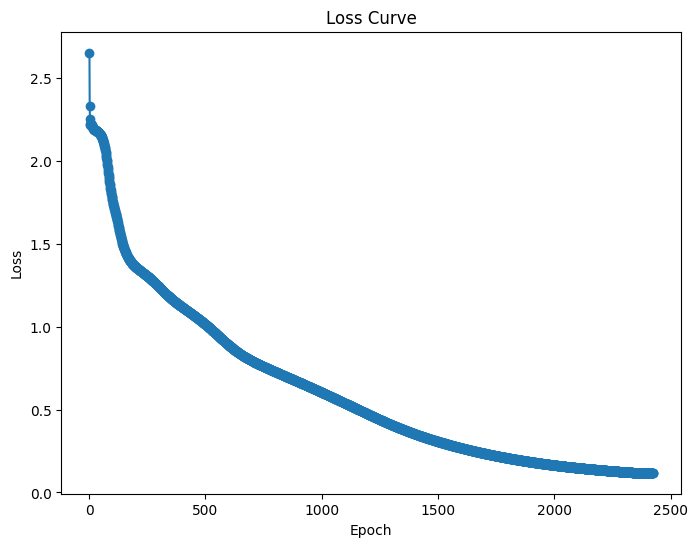

Accuracy: 0.6153846153846154
Confusion matrix:
 [[2 3 0 0 0 0 0 0 0 0]
 [1 3 1 0 0 0 0 0 0 1]
 [0 2 1 0 0 0 0 0 0 0]
 [0 0 1 3 0 0 0 0 0 0]
 [1 0 0 0 8 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 4 1 0 0]
 [0 0 0 0 1 0 0 3 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


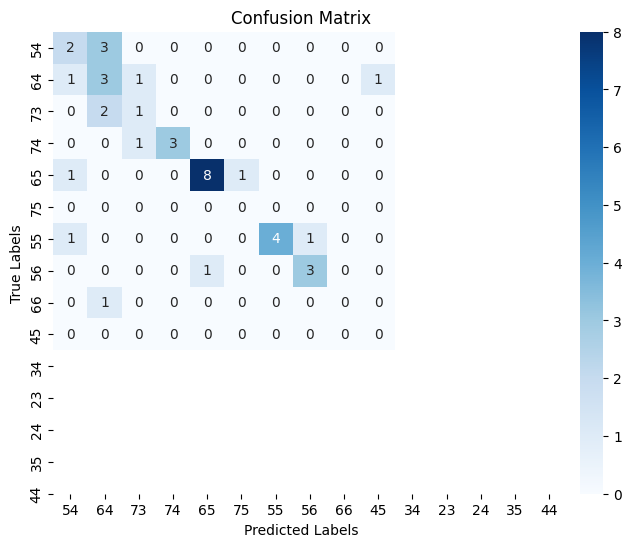

In [29]:
# from src.classifier import classifier

model = classifier(events_data)

In [32]:
# use model to predict chunks

model.predict(events_data.iloc[1])

ValueError: could not convert string to float: 'A3'

In [30]:
# use pymoo and nsga2 to find optimal threshold values

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize

algorithm = NSGA2(
    pop_size=40,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True,
)


termination = get_termination("n_gen", 40)

from src.classifier_new import Classifier

problem = Classifier(events_data)


res = minimize(problem, algorithm, termination, seed=1, save_history=True, verbose=True)

X = res.X
F = res.F

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       40 |      1 |           INF |           INF |             - |             -
     2 |       50 |      1 |           INF |           INF |             - |             -
     3 |       60 |      1 |           INF |           INF |             - |             -
     4 |       70 |      1 |           INF |           INF |             - |             -
     5 |       80 |      1 |           INF |           INF |             - |             -
     6 |       90 |      1 |           INF |           INF |             - |             -
     7 |      100 |      1 |           INF |           INF |             - |             -
     8 |      110 |      1 |           INF |           INF |             - |             -
     9 |      120 |      1 |           INF |           INF |             - |             -
    10 |      130 |      1 |           INF |           INF |             - |             -